# Song Recomendation

With this project, I aim to create a song recomendation system. To do that, I have scraped the Billboard Top 100 list of songs and got som data from Spotify about song features, to create clusters. The original idea was to cluster the songs by genre, but the Spotify API has some limitaitions for genres and can only give genre recomendation seeds, which are not sufficient. For now, the project will function as follows:

- First, we ask the user to input a song or artist

- Then, we will check if the song or artist is present in the Billboard Top 100 list.

- If so, we will recommend a song from that list if the user gave a song name, and a song from the artist if the input was the artist name.

- If the song/artist is not present in the input from the user, we will then ask for a specific song of the artist from the input if that was the orignal input.

- We will use the Spotipy library to get the song features of the song.

- The next step will be to run those features through the KMeans algorithm to assign it a cluster.

- Then, we will recommend a song from that cluster that is no the same song.

- We will ask the user if he wants a new song recomendation if so, we will give a new song, that is not the same as the two before, by creating a list of the songs given, until the user wants to end the process.

In [18]:
#Importing the libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import dotenv
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import PySimpleGUI as sg
import kaggle
warnings.filterwarnings("ignore")

In [23]:
#We will start by loading the data
url = "https://dl.dropboxusercontent.com/scl/fi/zc5e1lnzzjw7knzh58vgy/tracks_features.csv?rlkey=6lkmcs1z9ik6gjyj92blk9bw4"
billboard = pd.read_csv(r'files\billboard_hot_100.csv')
features = pd.read_csv(url)

In [13]:
#Next we will initialize Spotipy
dotenv.load_dotenv()
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [24]:
#We will check the data
display(billboard.head())
display(features.head())

,Song,Artist
0,We Can't Be Friends (Wait For Your Love),Ariana Grande
1,Lose Control,Teddy Swims
2,Beautiful Things,Benson Boone
3,Carnival,¥$: Ye & Ty Dolla $ign Featuring Rich The Kid ...
4,Lovin On Me,Jack Harlow


,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [11]:
#We will check the data types
display(billboard.dtypes)
display(features.dtypes)

Song      object
Artist    object
dtype: object

<!DOCTYPE html><html><head><title>Google Drive - Virus scan warning</title><meta http-equiv="content-type" content="text/html; charset=utf-8"/><style nonce="4vbU-UXIU_D_Wfn6PQs7mw">.goog-link-button{position:relative;color:#15c;text-decoration:underline;cursor:pointer}.goog-link-button-disabled{color:#ccc;text-decoration:none;cursor:default}body{color:#222;font:normal 13px/1.4 arial                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [7]:
#Creating a function to get the song features, year, duration, explicit, and time signature
def get_song_features(track_id):
    track = sp.track(track_id)
    features = sp.audio_features(track_id)
    song = {
        'explicit': track['explicit'],
        'danceability': features[0]['danceability'],
        'energy': features[0]['energy'],
        'key': features[0]['key'],
        'loudness': features[0]['loudness'],
        'mode': features[0]['mode'],
        'speechiness': features[0]['speechiness'],
        'acousticness': features[0]['acousticness'],
        'instrumentalness': features[0]['instrumentalness'],
        'liveness': features[0]['liveness'],
        'valence': features[0]['valence'],
        'tempo': features[0]['tempo'],
        'duration_ms': features[0]['duration_ms'],
        'time_signature': features[0]['time_signature'],
        'year': track['album']['release_date'][:4],
        'track_id': track_id,
        'name': track['name'],
        'artist': track['artists'][0]['name'],
    }
    return [song]

In [8]:
#Function to get the most popular song of the artist
def get_popular_song(artist):
    results = sp.search(q=artist, limit=1)
    artist_id = results['tracks']['items'][0]['artists'][0]['id']
    top_tracks = sp.artist_top_tracks(artist_id)
    return top_tracks['tracks'][0]['id']

In [9]:
#Testing the function
print(get_song_features('6f3Slt0GbA2bPZlz0aIFXN'))


[{'explicit': False, 'danceability': 0.798, 'energy': 0.62, 'key': 8, 'loudness': -7.079, 'mode': 0, 'speechiness': 0.232, 'acousticness': 0.414, 'instrumentalness': 0.0192, 'liveness': 0.112, 'valence': 0.235, 'tempo': 120.031, 'duration_ms': 164000, 'time_signature': 4, 'year': '2020', 'track_id': '6f3Slt0GbA2bPZlz0aIFXN', 'name': 'The Business', 'artist': 'Tiësto'}]


In [10]:
#Now, we will create a dataframe with the features of the songs in the features dataframe
selected_features = features.drop(columns=['id', 'name', 'album', 'album_id', 'artists', 'artist_ids', 'track_number', 'disc_number', 'release_date'])

In [14]:
selected_features.head()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year
0,False,0.470,0.978,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999
1,True,0.599,0.957,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999
2,False,0.315,0.970,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999
3,True,0.440,0.967,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999
4,False,0.426,0.929,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999


In [15]:
#Now, we will scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)


In [16]:
#The next step will be to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

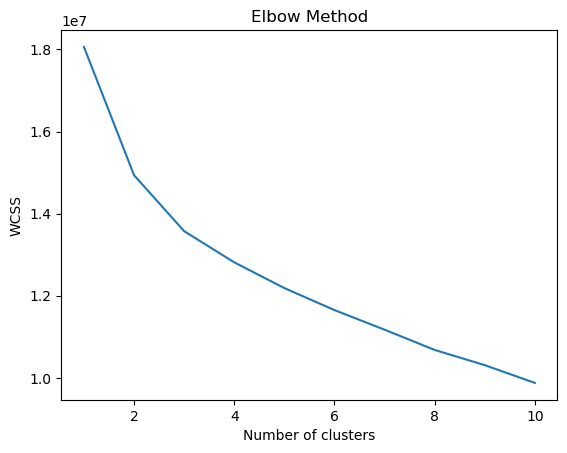

In [15]:
#Plotting the elbow method
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
#Using the information from the plot, we will use 4 clusters to group the songs
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(scaled_features)

#Now, I will save the clusters in a new variable
cluster = kmeans.predict(scaled_features)

#Now, we will unite the clusters with the features and song information
clustered_features = pd.DataFrame(scaled_features, columns=selected_features.columns)
clustered_features['name'] = features['name']
clustered_features['artists'] = features['artists']
clustered_features['album'] = features['album']
clustered_features['cluster'] = cluster
#Checking the new dataframe
display(clustered_features.head())



,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,name,artists,album,cluster
0,-0.271482,-0.121562,1.589717,0.510599,0.918016,0.699495,-0.100716,-1.092029,-0.751691,0.855599,0.277330,0.008781,-0.238621,0.298487,-0.688183,Testify,['Rage Against The Machine'],The Battle Of Los Angeles,1
1,3.683491,0.558569,1.518454,1.641587,0.865739,0.699495,0.893324,-1.126297,-0.751533,-0.258227,0.225571,-0.451057,-0.262868,0.298487,-0.688183,Guerrilla Radio,['Rage Against The Machine'],The Battle Of Los Angeles,0
2,-0.271482,-0.938773,1.562569,0.510599,0.914435,0.699495,3.436618,-1.099039,-0.751715,-0.441094,-0.214381,1.038065,0.308569,0.298487,-0.688183,Calm Like a Bomb,['Rage Against The Machine'],The Battle Of Los Angeles,1
3,3.683491,-0.279732,1.552388,1.641587,0.856287,-1.429603,1.315769,-0.736631,-0.751711,-0.446636,0.539822,-0.674995,-0.217001,0.298487,-0.688183,Mic Check,['Rage Against The Machine'],The Battle Of Los Angeles,0
4,-0.271482,-0.353544,1.423437,-0.903137,0.727529,0.699495,-0.123132,-1.155581,-0.472676,-0.679930,0.410424,0.304640,-0.266567,0.298487,-0.688183,Sleep Now In the Fire,['Rage Against The Machine'],The Battle Of Los Angeles,1


In [18]:
#Getting the information of the clusters
clustered_features.groupby(['cluster', 'name', 'artists'], as_index=False).count().sort_values(['cluster', 'key'], ascending=[True, False])[['name', 'artists', 'cluster', 'key']].reset_index(drop=True)

,name,artists,cluster,key
0,Don't Let Go (Love),['En Vogue'],0,19
1,(applause/banter),['Allison Crowe'],0,12
2,Edward R. Murrow: Narration,['Louis Armstrong'],0,8
3,"Das Christ-Elflein, Op. 20: Act I: Zwischentex...","['Hans Pfitzner', 'Andrea Sokol', 'Marlis Pete...",0,7
4,Music Intro,['David Chesky'],0,7
...,...,...,...,...
1149567,ꜤÎdû ilayya l-wisâl - Live at Institut du mond...,['Abderrahim Souiri'],3,1
1149568,그녀를 위해,['빛과 소금'],3,1
1149569,"﻿String Quartet No. 2 in F Major, Op. 41 No. 2...","['Robert Schumann', 'Dover Quartet']",3,1
1149570,"﻿String Quartet No. 2 in F Major, Op. 41 No. 2...","['Robert Schumann', 'Dover Quartet']",3,1


In [15]:
#Testing the logic

#Asking the user if they want to search by song or artist
select = input('Do you want to search by song or artist? ')
out_song = ''

#If the user selects song, we will ask for the name of the song
if select.lower() == 'song':
    song = input('Enter the name of a song: ')
    #Checking if the song is in the Billboard Hot 100
    if song in list(billboard['Song']):
        filtered_billboard = billboard[billboard['Song'] != song]
        random_song = filtered_billboard.sample()
        print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
    #If the song is not in the Billboard Hot 100, we will ask the user if they want a random song that is not in the Billboard Hot 100
    else:
        print('The song is not in the Billboard Hot 100')
        out_song = input('Would you like a random song that is not in the Billboard Hot 100? (Y/N) ')

#If the user selects artist, we will ask for the name of the artist
else:
    artist = input('Enter the name of the artist: ')
    #Checking if the artist is in the Billboard Hot 100
    if artist in list(billboard['Artist']):
        #Getting a random song from the artist
        filtered_billboard = billboard[billboard['Artist'] == artist]
        random_song = filtered_billboard.sample()
        print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
    #If the artist is not in the Billboard Hot 100, we will ask the user if they want a random song that is not in the Billboard Hot 100
    else:
        print('The artist is not in the Billboard Hot 100')
        out_song = input('Would you like a random song that is not in the Billboard Hot 100? (Y/N) ')

#If the users wants a random song, we will get a random song until the user decides to stop      
while out_song.lower() == 'y':
    #Asking the user for the name of a song they like
    song = input('Enter the name of a song you like: ')

    #Searching for the song in the features dataframe and recommending a song that is in the same cluster
    if song in list(features['name']):
        song_index = features[features['name'] == song].index[0]
        song_features = selected_features.iloc[song_index]
        song_features = scaler.transform([song_features])
        song_cluster = kmeans.predict(song_features)
        similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
        print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
        out_song = input('Would you like another recommendation? (Y/N) ')

    #If the song is not in the features dataframe, we will search for the song in Spotify and recommend a song that is in the same cluster
    elif song not in list(features['name']):
        
        #Searching for the song in Spotify with the help of Spotipy
        results = sp.search(q=song, limit=1)

        #Getting the song features
        song_id = results['tracks']['items'][0]['id']
        song_features = get_song_features(song_id)
        song_features = pd.DataFrame(song_features)
        song_features = song_features.drop(columns=['track_id', 'name', 'artist'])
        song_features = scaler.transform(song_features)
        song_cluster = kmeans.predict(song_features)
        similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
        print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
        out_song = input('Would you like another recommendation? (Y/N) ')
    else:
        print('Impossible to find the song')
        out_song = input('Would you like another recommendation? (Y/N) ')
print('Thank you for using the program!')

The song is not in the Billboard Hot 100


HTTP Error for GET to https://api.spotify.com/v1/search with Params: {'q': '', 'limit': 1, 'offset': 0, 'type': 'track', 'market': None} returned 400 due to No search query


SpotifyException: http status: 400, code:-1 - https://api.spotify.com/v1/search?q=&limit=1&offset=0&type=track:
 No search query, reason: None

In [16]:
def song_recommender():
    """
    Recommends a song based on user input of song or artist name.
    Uses the Billboard Hot 100 and Spotify data to provide recommendations.
    """

    # Asking the user if they want to search by song or artist
    select = input('Do you want to search by song or artist? ')
    out_song = ''

    # If the user selects song, we will ask for the name of the song
    if select.lower() == 'song':
        song = input('Enter the name of a song: ')
        
        # Checking if the song is in the Billboard Hot 100
        if song in list(billboard['Song']):
            filtered_billboard = billboard[billboard['Song'] != song]
            random_song = filtered_billboard.sample()
            print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
        
        # If the song is not in the Billboard Hot 100, we will ask the user if they want a random song that is not in the Billboard Hot 100
        else:
            print('The song is not in the Billboard Hot 100')
            out_song = input('Would you like a random song that is not in the Billboard Hot 100? (Y/N) ')

    # If the user selects artist, we will ask for the name of the artist
    else:
        artist = input('Enter the name of the artist: ')
        
        # Checking if the artist is in the Billboard Hot 100
        if artist in list(billboard['Artist']):
            # Getting a random song from the artist
            filtered_billboard = billboard[billboard['Artist'] == artist]
            random_song = filtered_billboard.sample()
            print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
        
        # If the artist is not in the Billboard Hot 100, we will ask the user if they want a random song that is not in the Billboard Hot 100
        else:
            print('The artist is not in the Billboard Hot 100')
            out_song = input('Would you like a random song that is not in the Billboard Hot 100? (Y/N) ')

    # If the users wants a random song, we will get a random song until the user decides to stop
    while out_song.lower() == 'y':
        # Asking the user for the name of a song they like
        if select.lower() == 'song':
            # Searching for the song in the features dataframe and recommending a song that is in the same cluster
            if song in list(features['name']):
                song_index = features[features['name'] == song].index[0]
                song_features = selected_features.iloc[song_index]
                song_features = scaler.transform([song_features])
                song_cluster = kmeans.predict(song_features)
                similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                out_song = input('Would you like another recommendation? (Y/N) ')

            # If the song is not in the features dataframe, we will search for the song in Spotify and recommend a song that is in the same cluster
            elif song not in list(features['name']):
                
                # Searching for the song in Spotify with the help of Spotipy
                results = sp.search(q=song, limit=1)

                # Getting the song features
                song_id = results['tracks']['items'][0]['id']
                song_features = get_song_features(song_id)
                song_features = pd.DataFrame(song_features)
                song_features = song_features.drop(columns=['track_id', 'name', 'artist'])
                song_features = scaler.transform(song_features)
                song_cluster = kmeans.predict(song_features)
                similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                out_song = input('Would you like another recommendation? (Y/N) ')
            
            else:
                print('Impossible to find the song')
                out_song = input('Would you like another recommendation? (Y/N) ')
        elif select.lower() == 'artist':
            #Getting the artist's most popular song
            song_id = get_popular_song(artist)
            song_features = get_song_features(song_id)
            song_features = pd.DataFrame(song_features)
            song_features = song_features.drop(columns=['track_id', 'name', 'artist'])
            song_features = scaler.transform(song_features)
            song_cluster = kmeans.predict(song_features)
            similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
            print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
            out_song = input('Would you like another recommendation? (Y/N) ')
        
    print('Thank you for using the program!')
    

In [ ]:
#Testing the function
song_recommender()

The song is not in the Billboard Hot 100
We recommend the song Ode by ['Dieter Ilg', 'Rainer Böhm', 'Patrice Heral']
Thank you for using the program!


In [19]:
# Defining the GUI layout
layout = [[sg.Text('Song Recommender')],
          [sg.Text('Do you want to search by song or artist?')],
          [sg.Radio('Song', "RADIO1", key='-RADIO1-'), sg.Radio('Artist', "RADIO2", key='-RADIO2-')],
          [sg.InputText(key='-INPUT-'), sg.Button('Submit')],
          [sg.Text('Recommendations will appear here:')],
          [sg.Output(size=(40, 10))]]

# Creating the GUI window
window = sg.Window('Song Recommender', layout)

#Initializing the value of select
select = True

# Defining the event loop
while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED:
        break
    if event == 'Submit':
        if select:
            if values['-RADIO1-']:
                song = values['-INPUT-']
                if song in list(billboard['Song']):
                    filtered_billboard = billboard[billboard['Song']!= song]
                    random_song = filtered_billboard.sample()
                    print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
                elif song not in list(billboard['Song']):
                    print('The song is not in the Billboard Hot 100')
                    result = sg.popup_yes_no('Would you like a random song that is not in the Billboard Hot 100?')
                    if result == 'Yes':
                        if song in list(features['name']):
                            song_index = features[features['name'] == song].index[0]
                            song_features = selected_features.iloc[song_index]
                            song_features = scaler.transform([song_features])
                            song_cluster = kmeans.predict(song_features)
                            similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                            print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                        elif song not in list(features['name']):
                            results = sp.search(q=song, limit=1)
                            song_id = results['tracks']['items'][0]['id']
                            song_features = get_song_features(song_id)
                            song_features = pd.DataFrame(song_features)
                            song_features = song_features.drop(columns=['track_id', 'name', 'artist'])
                            song_features = scaler.transform(song_features)
                            song_cluster = kmeans.predict(song_features)
                            while True:
                                similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                                print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                                result = sg.popup_yes_no('Would you like another recommendation?')
                                if result != 'Yes':
                                    break
                                new_song_features = scaler.transform(song_features)
                                new_song_cluster = kmeans.predict(new_song_features)
                                song_cluster = new_song_cluster
                else:
                    print('Impossible to find the song')
                    result = sg.popup_yes_no('Would you like to search for another song?')
                    if result == 'Yes':
                        song = values['-INPUT-']
                    if song in list(billboard['Song']):
                        filtered_billboard = billboard[billboard['Song']!= song]
                        random_song = filtered_billboard.sample()
                        print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
                    else:
                        print('The song is not in the Billboard Hot 100')
                        result = sg.popup_yes_no('Would you like a random song that is not in the Billboard Hot 100?')
                        if result == 'Yes':
                            if song in list(features['name']):
                                song_index = features[features['name'] == song].index[0]
                                song_features = selected_features.iloc[song_index]
                                song_features = scaler.transform([song_features])
                                song_cluster = kmeans.predict(song_features)
                                while True:
                                    similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                                    print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                                    result = sg.popup_yes_no('Would you like another recommendation?')
                                    if result != 'Yes':
                                        print('Thank you for using the program!')
                                        break
                                    new_song_features = scaler.transform(song_features)
                                    new_song_cluster = kmeans.predict(new_song_features)
                                    song_cluster = new_song_cluster
                            elif song not in list(features['name']):
                                results = sp.search(q=song, limit=1)
                                song_id = results['tracks']['items'][0]['id']
                                song_features = get_song_features(song_id)
                                song_features = pd.DataFrame(song_features)
                                song_features = song_features.drop(columns=['track_id', 'name', 'artist'])
                                song_features = scaler.transform(song_features)
                                song_cluster = kmeans.predict(song_features)
                                while True:
                                    similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                                    print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                                    result = sg.popup_yes_no('Would you like another recommendation?')
                                    if result != 'Yes':
                                        print('Thank you for using the program!')
                                        break
                                    new_song_features = scaler.transform(song_features)
                                    new_song_cluster = kmeans.predict(new_song_features)
                                    song_cluster = new_song_cluster
                                
            else:
                artist = values['-INPUT-']
                if artist in list(billboard['Artist']):
                    filtered_billboard = billboard[billboard['Artist'] == artist]
                    random_song = filtered_billboard.sample()
                    print(f'We recommend the song {random_song["Song"].values[0]} by {random_song["Artist"].values[0]}')
                else:
                    print('The artist is not in the Billboard Hot 100')
                    result = sg.popup_yes_no('Would youlike a random song that is not in the Billboard Hot 100? (Y/N)')
                    if result == 'Yes':
                        song_id = get_popular_song(artist)
                        song_features = get_song_features(song_id)
                        song_features = pd.DataFrame(song_features)
                        song_features = song_features.drop(columns=['track_id', 'name', 'artist'])
                        song_features = scaler.transform(song_features)
                        song_cluster = kmeans.predict(song_features)
                        while True:
                            similar_songs = clustered_features[clustered_features['cluster'] == song_cluster[0]].sample()
                            print(f'We recommend the song {similar_songs["name"].values[0]} by {similar_songs["artists"].values[0]}')
                            result = sg.popup_yes_no('Would you like another recommendation?')
                            if result != 'Yes':
                                break
                            new_song_features = scaler.transform(song_features)
                            new_song_cluster = kmeans.predict(new_song_features)
                            song_cluster = new_song_cluster
                    else:
                        print('Thank you for using the program!')
                        break

# Closing the GUI window
window.close()